# Bayesian Exploration
Here we demonstrate the use of Bayesian Exploration to characterize an unknown
function in the presence of constraints (see [here](https://www.nature.com/articles/s41467-021-25757-3)).
The function we wish to explore is the first objective of the TNK test problem.

## Specifiying generator options
We start with the generator defaults and modify as needed for conservative
exploration, which should prevent any constraint violations.

In [1]:
# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import torch
import yaml
from copy import deepcopy
from xopt import Xopt, Evaluator
from xopt.generators.bayesian import BayesianExplorationGenerator
from xopt.resources.test_functions.tnk import evaluate_TNK, tnk_vocs

vocs = deepcopy(tnk_vocs)

# can only explore one objective
del vocs.objectives["y2"]

generator_options = BayesianExplorationGenerator.default_options()
generator_options.optim.num_restarts = 20
generator_options.optim.raw_samples = 20
generator_options.optim.max_travel_distances = [0.25, 0.25]

evaluator = Evaluator(function=evaluate_TNK)
generator = BayesianExplorationGenerator(vocs, generator_options)

print(yaml.dump(generator.options.dict()))

acq:
  monte_carlo_samples: 128
  proximal_lengthscales: null
  use_transformed_proximal_weights: true
model:
  covar_modules: {}
  custom_constructor: null
  mean_modules: {}
  name: standard
  use_low_noise_prior: true
n_initial: 3
optim:
  max_travel_distances:
  - 0.25
  - 0.25
  num_restarts: 20
  raw_samples: 20
  sequential: true
  use_turbo: false
use_cuda: false



## Run exploration
We start with evaluating 2 points that we know satisfy the constraints. We then run
30 exploration steps.

In [2]:
X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs)
X.evaluate_data(pd.DataFrame({"x1":[1.0, 0.75],"x2":[0.7, 0.95]}))

,x1,x2,y1,y2,c1,c2,some_array,xopt_runtime,xopt_error
1,1.00,0.70,1.00,0.70,0.584045,0.290,"[1, 2, 3]",0.000093,False
2,0.75,0.95,0.75,0.95,0.494833,0.265,"[1, 2, 3]",0.000017,False


In [3]:
for i in range(10):
    print(f"step {i}")
    X.step()

step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9


In [4]:
# view the data
X.data

,x1,x2,y1,y2,c1,c2,some_array,xopt_runtime,xopt_error,a
1,1.000000,0.700000,1.000000,0.700000,0.584045,0.290000,"[1, 2, 3]",0.000093,False,NaN
2,0.750000,0.950000,0.750000,0.950000,0.494833,0.265000,"[1, 2, 3]",0.000017,False,NaN
3,1.535397,1.735397,1.535397,1.735397,4.313110,2.598255,"[1, 2, 3]",0.000039,False,dummy_constant
4,1.632527,1.488932,1.632527,1.488932,3.807915,2.260604,"[1, 2, 3]",0.000040,False,dummy_constant
5,1.201986,1.043079,1.201986,1.043079,1.490173,0.787720,"[1, 2, 3]",0.000039,False,dummy_constant
6,0.417775,1.037857,0.417775,1.037857,0.152963,0.296051,"[1, 2, 3]",0.000040,False,dummy_constant
7,0.825246,0.625785,0.825246,0.625785,0.130325,0.121607,"[1, 2, 3]",0.000040,False,dummy_constant
8,1.036238,0.498639,1.036238,0.498639,0.259702,0.287553,"[1, 2, 3]",0.000040,False,dummy_constant
9,0.896875,1.010793,0.896875,1.010793,0.768270,0.418419,"[1, 2, 3]",0.000039,False,dummy_constant
10,1.137525,0.386922,1.137525,0.386922,0.392816,0.419224,"[1, 2, 3]",0.000039,False,dummy_constant


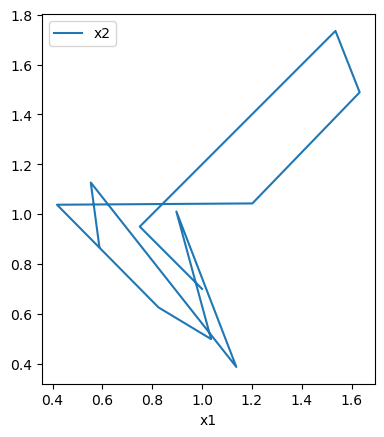

In [5]:
# plot results
ax = X.data.plot("x1", "x2")
ax.set_aspect("equal")

## Introspect models
During exploration we generate Gaussian Process models of each objective and
constraint. We demonstrate how they are viewed below.

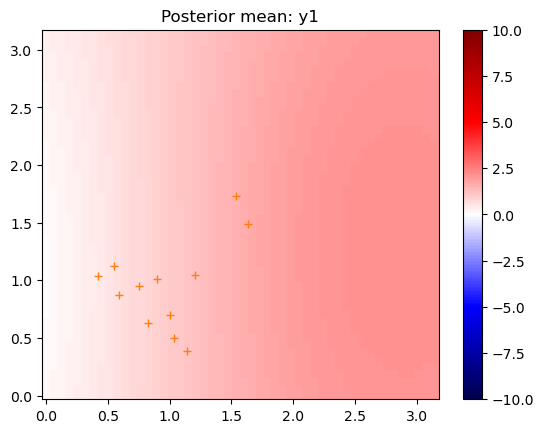

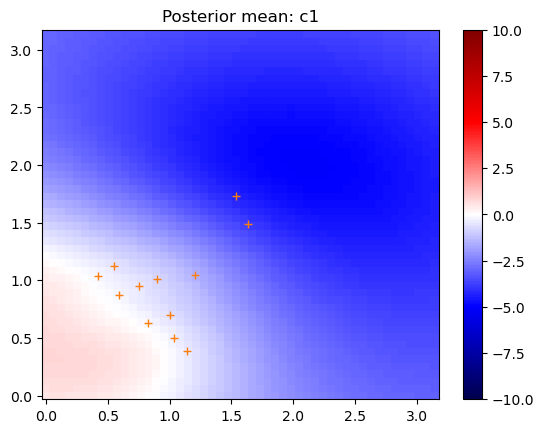

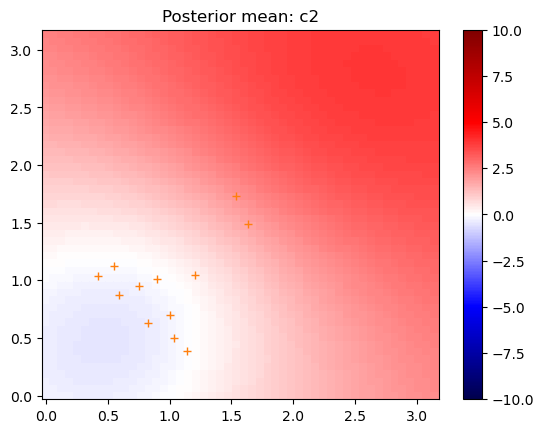

In [6]:
from matplotlib import pyplot as plt  # plot model predictions

data = X.data

bounds = generator.vocs.bounds
model = generator.train_model(generator.data)

# create mesh
n = 50
x = torch.linspace(*bounds.T[0], n)
y = torch.linspace(*bounds.T[1], n)
xx, yy = torch.meshgrid(x, y)
pts = torch.hstack([ele.reshape(-1, 1) for ele in (xx, yy)]).double()

outputs = generator.vocs.output_names
with torch.no_grad():
    post = model.posterior(pts)

    for i in range(len(vocs.output_names)):
        mean = post.mean[...,i]
        fig, ax = plt.subplots()
        ax.plot(*data[["x1", "x2"]].to_numpy().T, "+C1")
        c = ax.pcolor(
            xx, yy, mean.squeeze().reshape(n, n),
            cmap="seismic",
            vmin=-10.0,
            vmax=10.0)
        fig.colorbar(c)
        ax.set_title(f"Posterior mean: {outputs[i]}")

## View acquisition function and feasibility prediction

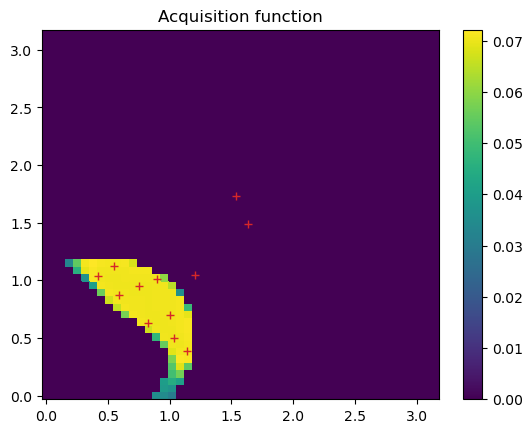

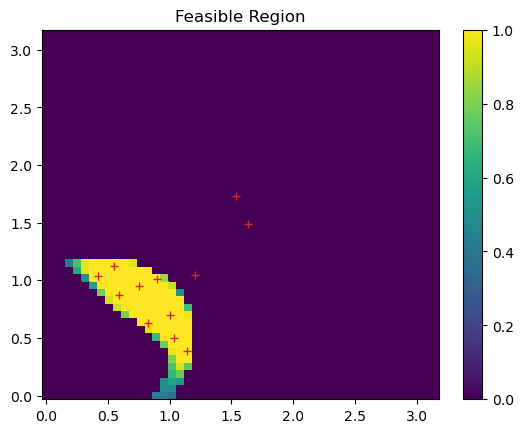

In [7]:
from xopt.generators.bayesian.objectives import feasibility

acq_func = generator.get_acquisition(model)
with torch.no_grad():
    acq_pts = pts.unsqueeze(1)
    acq = acq_func(acq_pts)

    fig, ax = plt.subplots()
    c = ax.pcolor(xx, yy, acq.reshape(n, n))
    ax.plot(*data[["x1", "x2"]].to_numpy().T, "+C3")

    fig.colorbar(c)
    ax.set_title("Acquisition function")

    feas = feasibility(pts.unsqueeze(1), model, generator.sampler, vocs).flatten()

    fig2, ax2 = plt.subplots()
    c = ax2.pcolor(xx, yy, feas.reshape(n, n))
    ax2.plot(*data[["x1", "x2"]].to_numpy().T, "+C3")

    fig2.colorbar(c)
    ax2.set_title("Feasible Region")

## Generator model hyperparameters

In [8]:
# print generator model hyperparameters
for name, val in X.generator.model.named_parameters():
    print(f"{name}:{val}")

X.generator.model.models[2].covar_module.base_kernel.lengthscale

models.0.likelihood.noise_covar.raw_noise:Parameter containing:
tensor([-21.0543], dtype=torch.float64, requires_grad=True)
models.0.mean_module.raw_constant:Parameter containing:
tensor(0.1075, dtype=torch.float64, requires_grad=True)
models.0.covar_module.raw_outputscale:Parameter containing:
tensor(3.8783, dtype=torch.float64, requires_grad=True)
models.0.covar_module.base_kernel.raw_lengthscale:Parameter containing:
tensor([[0.0671, 0.9175]], dtype=torch.float64, requires_grad=True)
models.1.mean_module.raw_constant:Parameter containing:
tensor(-0.8435, dtype=torch.float64, requires_grad=True)
models.1.covar_module.raw_outputscale:Parameter containing:
tensor(2.7520, dtype=torch.float64, requires_grad=True)
models.1.covar_module.base_kernel.raw_lengthscale:Parameter containing:
tensor([[-0.2789, -0.8140]], dtype=torch.float64, requires_grad=True)
models.2.mean_module.raw_constant:Parameter containing:
tensor(2.3895, dtype=torch.float64, requires_grad=True)
models.2.covar_module.raw

tensor([[0.7480, 0.6790]], dtype=torch.float64, grad_fn=<SoftplusBackward0>)

## Examine the number of constraint violations
Using the convience function provided by the vocs object we can evaluate which
samples violate either or both of our constraints.

In [9]:
X.vocs.feasibility_data(X.data)

,feasible_c1,feasible_c2,feasible
1,True,True,True
2,True,True,True
3,True,False,False
4,True,False,False
5,True,False,False
6,True,True,True
7,True,True,True
8,True,True,True
9,True,True,True
10,True,True,True


In [10]:
# generate next point
X.generator.generate(1)

,x1,x2,a
0,1.109866,0.277567,dummy_constant
